## FlowMatchingActionExpert Cross-Attention Heatmap

이 노트북은 `FlowMatchingActionExpert` / `ModulatedDecoderLayer`에서 추출한 cross-attention 가중치를 시각화합니다.
- Vision 토큰과 Sensor(+Robot) 토큰을 하나의 메모리로 구성
- 마지막 디코더 층의 cross-attention weight를 저장 후 heatmap으로 표현
- Vision 대비 Sensor 중요도 비율을 곡선으로 확인

더미 텐서를 사용하지만, 실제 피쳐로 교체하면 그대로 활용할 수 있습니다.

In [1]:
import torch
import matplotlib.pyplot as plt
from models.action_decoder import FlowMatchingActionExpert

# CUDA가 있으면 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
# FlowMatchingActionExpert 초기화 (필요 시 config에 맞춰 수정)
flow_model = FlowMatchingActionExpert(
    image_feature_dim=2048,
    text_guidance_dim=2048,
    sensor_dim=2048,
    action_dim=7,
    horizon=8,
    hidden_dim=512,
    nhead=8,
    num_decoder_layers=4,
    dropout=0.1,
)
flow_model = flow_model.to(device).eval()

# 더미 입력 (실제 실험에서는 아래 텐서를 실제 feature로 교체)
B = 1
Sv, Ss = 16, 8  # vision / sensor token 길이
D_img = flow_model.context_proj.in_features
D_sensor = flow_model.sensor_proj.in_features
guidance_dim = flow_model.text_guidance_proj.in_features
H, action_dim = flow_model.horizon, flow_model.action_dim

context_features = torch.randn(B, Sv, D_img, device=device)
sensor_features = torch.randn(B, Ss, D_sensor, device=device)
guidance_vector = torch.randn(B, guidance_dim, device=device)
actions = torch.randn(B, H, action_dim, device=device)
print({
    "context_features": tuple(context_features.shape),
    "sensor_features": tuple(sensor_features.shape),
    "guidance_vector": tuple(guidance_vector.shape),
    "actions": tuple(actions.shape),
})


✅ FlowMatchingActionExpert V2 (Cross-Attention + ModulatedDecoder) 초기화 완료
   4개의 ModulatedDecoderLayer 사용
{'context_features': (1, 16, 2048), 'sensor_features': (1, 8, 2048), 'guidance_vector': (1, 2048), 'actions': (1, 8, 7)}


In [3]:
# Flow Matching 단계: normalize -> flow -> forward
with torch.no_grad():
    actions_n = actions / flow_model.action_scale
    x_t, u_t, t_scalar = flow_model.flow.compute_flow_and_target(actions_n)
    _ = flow_model.forward(
        x_t,
        t_scalar,
        context_features,
        guidance_vector,
        sensor_features=sensor_features,
    )

attn = flow_model.mod_layers[-1].last_cross_attn_weights
if attn is None:
    raise RuntimeError("Cross-attention weights were not captured.")

attn = attn.detach().cpu()
attn_mean = attn.mean(dim=1)[0]  # (H, S)
Sv = context_features.shape[1]
Ss = sensor_features.shape[1]
print(f"attn_mean shape: {tuple(attn_mean.shape)}, Sv={Sv}, Ss={Ss}")


attn_mean shape: (8, 24), Sv=16, Ss=8


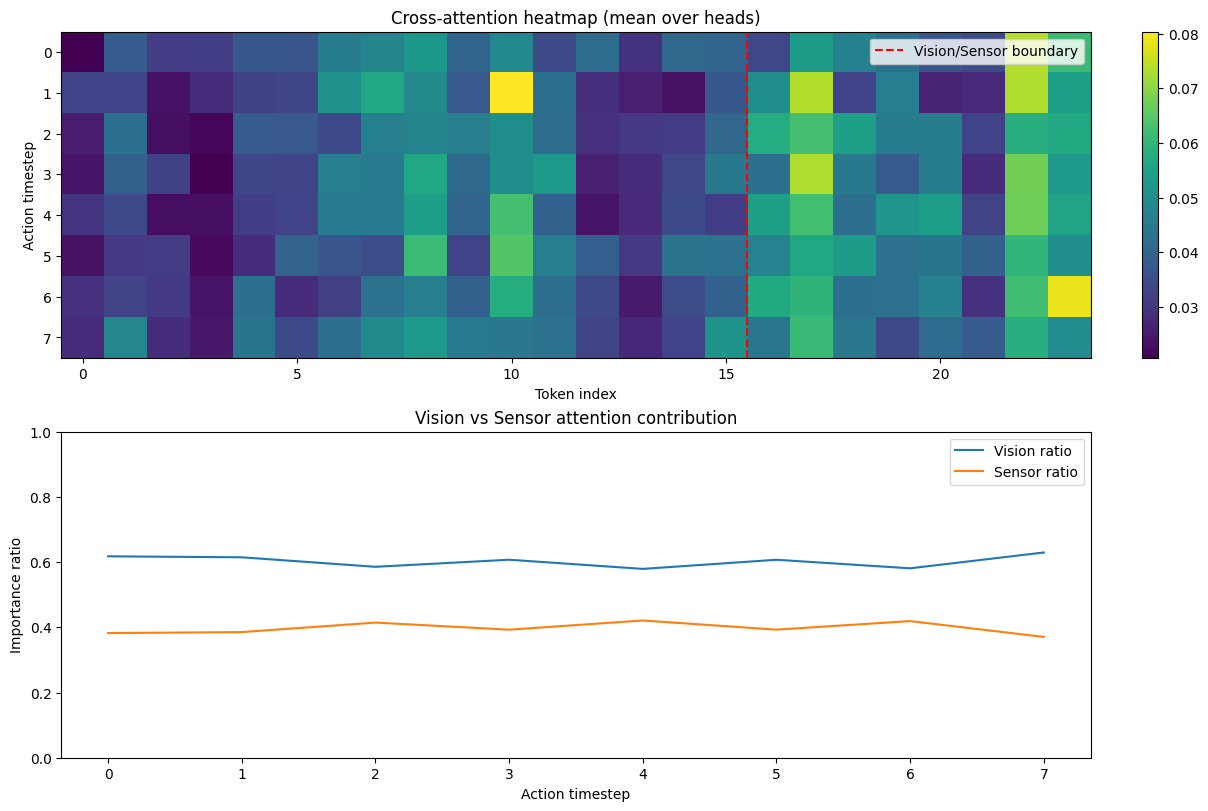

In [4]:
# Heatmap + Vision/Sensor 비율 시각화
S = attn_mean.shape[1]
vision_importance = attn_mean[:, :Sv].sum(dim=-1)
sensor_importance = attn_mean[:, Sv:].sum(dim=-1)
ratio = vision_importance / (vision_importance + sensor_importance + 1e-8)
steps = torch.arange(attn_mean.shape[0])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

im = axes[0].imshow(attn_mean.numpy(), aspect="auto", cmap="viridis")
axes[0].axvline(x=Sv - 0.5, color="red", linestyle="--", label="Vision/Sensor boundary")
axes[0].set_title("Cross-attention heatmap (mean over heads)")
axes[0].set_ylabel("Action timestep")
axes[0].set_xlabel("Token index")
axes[0].legend(loc="upper right")
fig.colorbar(im, ax=axes[0], fraction=0.025)

axes[1].plot(steps.numpy(), ratio.numpy(), label="Vision ratio", color="tab:blue")
axes[1].plot(steps.numpy(), (1 - ratio).numpy(), label="Sensor ratio", color="tab:orange")
axes[1].set_ylim(0, 1)
axes[1].set_title("Vision vs Sensor attention contribution")
axes[1].set_xlabel("Action timestep")
axes[1].set_ylabel("Importance ratio")
axes[1].legend()

plt.show()


## Episode-Level Cross-Attention Timeline (real data)

모든 피치 필드 대신 층스토링 구동을 사용하며, 지정한 에피소드를 순차적으로 순회해 모든 cross-attention 가중치를 수집합니다.  
- VL 캐시가 있다면 바로 불러오고, `use_cache=False`로 설정하면 노트북이 자동으로 Qwen 인코더를 호출해 라이브로 이미지 토큰을 만듭니다.  
- `MAX_STEPS`, `TARGET_STEP_IDX` 등은 조사 범위와 시각화 대상을 조절합니다.  
- `UnifiedVLADataset`은 순서를 유지하므로 결과 그래프의 x축을 원본 시간 축으로 해석하면 됩니다.  
- 멀티뷰 중 일부만 쓰려면 `views_to_use` 옵션을 지정해 빈 이미지 리스트가 나오지 않도록 해 주세요.


In [5]:
import numpy as np
from pathlib import Path
from tqdm import tqdm

from vla_datasets.unified_dataset import UnifiedVLADataset
from models.unified_model import QwenVLAUnified

EPISODE_PATH = Path("/home/najo/NAS/VLA/dataset/New_dataset4/Eye_trocar/data_collection_20251115_003810")
CACHE_ROOT = Path("/home/najo/NAS/VLA/dataset/cache/qwen_vl_features")
CHECKPOINT_PATH = Path("checkpoints/flow_matching_best.pt")

SENSOR_WINDOW = 65
ROBOT_WINDOW = 100
VLM_REUSE_COUNT = 3
ACTION_EXPERT_HZ = 10
MAX_STEPS = None
TARGET_STEP_IDX = 120

assert EPISODE_PATH.exists(), f"{EPISODE_PATH} not found"
assert CACHE_ROOT.exists(), f"{CACHE_ROOT} not found"
assert CHECKPOINT_PATH.exists(), f"{CHECKPOINT_PATH} not found"

print(f"Episode root: {EPISODE_PATH}")
print(f"Checkpoint: {CHECKPOINT_PATH}")


Episode root: /home/najo/NAS/VLA/dataset/New_dataset4/Eye_trocar/data_collection_20251115_003810
Checkpoint: checkpoints/flow_matching_best.pt


In [6]:
episode_dataset = UnifiedVLADataset(
    data_dir=str(EPISODE_PATH),
    format="auto",
    horizon=flow_model.horizon if 'flow_model' in globals() else 8,
    vlm_reuse_count=VLM_REUSE_COUNT,
    sensor_window_size=SENSOR_WINDOW,
    robot_window_size=ROBOT_WINDOW,
    action_expert_hz=ACTION_EXPERT_HZ,
    cache_root=str(CACHE_ROOT),
    use_cache=False,
    disable_sensor=False,
    disable_robot_state=False,
)
print(f"Total samples in episode: {len(episode_dataset)}")

flow_hidden_dim = flow_model.hidden_dim if 'flow_model' in globals() else 1024
flow_horizon = flow_model.horizon if 'flow_model' in globals() else 8
flow_action_dim = flow_model.action_dim if 'flow_model' in globals() else 7

vl_model_name = "Qwen/Qwen2.5-VL-3B-Instruct"

trained_model = QwenVLAUnified(
    model_type='flow_matching', vl_model_name=vl_model_name, action_dim=7, horizon=8,
    hidden_dim=1024, sensor_enabled=True,
    sensor_encoder_type='force_aware', # Match pre-training architecture
    sensor_input_channels=1026,
    sensor_temporal_length=65,
    sensor_hidden_dim=128,  # Conv backbone channels
    sensor_output_dim=1024,
    sensor_transformer_dim=256,  # Transformer projection
    robot_state_enabled=True,
    robot_state_output_dim=1024, # Match pre-training architecture
    image_resize_height=360, image_resize_width=640,
    device_map=None,
)

state = torch.load(str(CHECKPOINT_PATH), map_location='cpu')
loaded = state.get("model_state_dict", state)
missing, unexpected = trained_model.load_state_dict(loaded, strict=False)
if missing:
    print(f"Missing keys: {len(missing)} (first: {missing[:3]})")
if unexpected:
    print(f"Unexpected keys: {len(unexpected)} (first: {unexpected[:3]})")

trained_model.eval()
flow_model_trained = trained_model.action_expert
flow_model_trained.eval()
print("Loaded trained FlowMatchingActionExpert for episode sweep.")


Total samples in episode: 292
🚀 QwenVLA 통합 모델 V2 (Cross-Attention) 로딩 중
   모델 타입: FLOW_MATCHING
   센서 활성화: True
   로봇 상태 활성화: True
   Flow 스텝: 10, 솔버: euler
   이미지 리사이즈: 640x360
🧠 flash_attention_2 어텐션과 torch.bfloat16 데이터 타입으로 Qwen-VL 로드 시도 중...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Qwen-VL 모델 로드 성공: flash_attention_2 어텐션 (torch.bfloat16)
   VL 모델 hidden_size: 2048
🧊 VL 모델 매개변수 동결 중...
✅ VL 모델 동결 완료.
   센서 인코더 타입: Force-Aware
   📊 Conv backbone: 1025ch → ... → 1024ch (hidden_dim=128)
   🔧 Mode: Conv(1024) → Projection(256) → Transformer(256)
   💡 Lightweight mode
   💡 Lightweight mode: Conv(1024) → Projection(256) → Transformer


/home/najo/.conda/envs/qwen_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


✅ FlowMatchingActionExpert V2 (Cross-Attention + ModulatedDecoder) 초기화 완료
   4개의 ModulatedDecoderLayer 사용
✅ 모델 초기화 완료!
Loaded trained FlowMatchingActionExpert for episode sweep.


In [8]:
flow_device = next(flow_model_trained.parameters()).device
flow_dtype = next(flow_model_trained.parameters()).dtype
sensor_dtype = next(trained_model.sensor_encoder.parameters()).dtype if trained_model.sensor_encoder else flow_dtype
robot_dtype = next(trained_model.robot_state_encoder.parameters()).dtype if trained_model.robot_state_encoder else flow_dtype

max_steps = len(episode_dataset) if MAX_STEPS is None else min(len(episode_dataset), MAX_STEPS)

captured_attn = []
vision_ratio_series = []
vision_lengths = []
episode_indices = []
timestamps = []

for step in tqdm(range(max_steps), desc="Processing episode"):
    sample = episode_dataset[step]
    vl_cache = sample.get("vl_cache")
    use_cached_tokens = (
        isinstance(vl_cache, (tuple, list))
        and len(vl_cache) == 2
        and isinstance(vl_cache[0], torch.Tensor)
        and vl_cache[0].shape[1] > 0
    )

    if use_cached_tokens:
        vision_tokens, guidance_vec = vl_cache
        context_features = vision_tokens.to(device=flow_device, dtype=flow_dtype, non_blocking=True)
        guidance_vector = guidance_vec.to(device=flow_device, dtype=flow_dtype, non_blocking=True)
    else:
        image_paths = sample.get("images", ["View1","View2","View3","View4","View5" ])
        instruction = sample.get("instruction", "")
        cache_key = sample.get("cache_key", f"step_{step}")
        if not image_paths:
            print(f"[Step {step}] No images available for live VL encoding, skipping.")
            continue
        with torch.no_grad():
            img_tokens, txt_tokens = trained_model.vl_encoder.encode(
                [instruction], [image_paths], [cache_key], use_cache=False
            )
        if img_tokens.shape[1] == 0:
            print(f"[Step {step}] Live VL encoder returned 0 vision tokens, skipping.")
            continue
        context_features = img_tokens.to(device=flow_device, dtype=flow_dtype, non_blocking=True)
        guidance_vector = txt_tokens.to(device=flow_device, dtype=flow_dtype, non_blocking=True)

    sensor_data = sample["sensor_data"].unsqueeze(0).to(device=flow_device, dtype=sensor_dtype, non_blocking=True)
    robot_states = sample["robot_states"].unsqueeze(0).to(device=flow_device, dtype=robot_dtype, non_blocking=True)
    actions = sample["actions"].unsqueeze(0).to(device=flow_device, dtype=flow_dtype, non_blocking=True)

    sensor_chunks = []
    if trained_model.sensor_encoder is not None:
        sensor_chunks.append(trained_model.sensor_encoder(sensor_data))
    if trained_model.robot_state_encoder is not None:
        sensor_chunks.append(trained_model.robot_state_encoder(robot_states))
    if not sensor_chunks:
        print(f"[Step {step}] Sensor/robot features missing, skipping.")
        continue
    sensor_features = torch.cat(sensor_chunks, dim=-1).to(dtype=flow_dtype)

    actions_n = actions / flow_model_trained.action_scale.to(device=flow_device, dtype=flow_dtype)
    x_t, _, t_scalar = flow_model_trained.flow.compute_flow_and_target(actions_n)

    with torch.no_grad():
        _ = flow_model_trained(
            x_t,
            t_scalar,
            context_features,
            guidance_vector,
            sensor_features=sensor_features,
        )
        attn = flow_model_trained.mod_layers[-1].last_cross_attn_weights
    if attn is None:
        raise RuntimeError("Cross-attention weights were not captured.")
    attn_mean = attn.detach().mean(dim=1).cpu()[0]
    if captured_attn and attn_mean.shape[0] != captured_attn[0].shape[0]:
        print(f"[Step {step}] Horizon mismatch, skipping.")
        continue

    Sv = context_features.shape[1]
    vision_lengths.append(Sv)
    captured_attn.append(attn_mean)
    episode_indices.append(step)
    timestamps.append(sample.get("timestamp", float(step)))

    vision_importance = attn_mean[:, :Sv].sum(dim=-1)
    sensor_importance = attn_mean[:, Sv:].sum(dim=-1)
    ratio = vision_importance / (vision_importance + sensor_importance + 1e-8)
    vision_ratio_series.append(ratio.cpu())

if not captured_attn:
    raise RuntimeError("No valid steps processed. Check cache/checkpoint paths and VL encoding.")
print(f"Processed {len(captured_attn)} / {max_steps} steps with valid attention.")



Processing episode:   0%|          | 0/292 [00:00<?, ?it/s]

Processing episode:   0%|          | 1/292 [00:00<03:43,  1.30it/s]

[Step 0] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   1%|          | 2/292 [00:01<03:39,  1.32it/s]

[Step 1] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   1%|          | 3/292 [00:02<03:35,  1.34it/s]

[Step 2] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   1%|▏         | 4/292 [00:02<03:33,  1.35it/s]

[Step 3] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   2%|▏         | 5/292 [00:03<03:34,  1.34it/s]

[Step 4] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   2%|▏         | 6/292 [00:04<03:33,  1.34it/s]

[Step 5] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   2%|▏         | 7/292 [00:05<03:31,  1.35it/s]

[Step 6] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   3%|▎         | 8/292 [00:05<03:30,  1.35it/s]

[Step 7] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   3%|▎         | 9/292 [00:06<03:29,  1.35it/s]

[Step 8] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   3%|▎         | 10/292 [00:07<03:29,  1.34it/s]

[Step 9] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   4%|▍         | 11/292 [00:08<03:29,  1.34it/s]

[Step 10] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   4%|▍         | 12/292 [00:08<03:29,  1.34it/s]

[Step 11] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   4%|▍         | 13/292 [00:09<03:28,  1.34it/s]

[Step 12] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   5%|▍         | 14/292 [00:10<03:27,  1.34it/s]

[Step 13] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   5%|▌         | 15/292 [00:11<03:25,  1.35it/s]

[Step 14] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   5%|▌         | 16/292 [00:11<03:26,  1.34it/s]

[Step 15] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   6%|▌         | 17/292 [00:12<03:25,  1.34it/s]

[Step 16] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   6%|▌         | 18/292 [00:13<03:24,  1.34it/s]

[Step 17] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   7%|▋         | 19/292 [00:14<03:25,  1.33it/s]

[Step 18] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   7%|▋         | 20/292 [00:14<03:23,  1.34it/s]

[Step 19] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   7%|▋         | 21/292 [00:15<03:22,  1.34it/s]

[Step 20] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   8%|▊         | 22/292 [00:16<03:21,  1.34it/s]

[Step 21] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   8%|▊         | 23/292 [00:17<03:21,  1.33it/s]

[Step 22] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   8%|▊         | 24/292 [00:17<03:20,  1.33it/s]

[Step 23] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   9%|▊         | 25/292 [00:18<03:20,  1.33it/s]

[Step 24] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   9%|▉         | 26/292 [00:19<03:18,  1.34it/s]

[Step 25] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:   9%|▉         | 27/292 [00:20<03:18,  1.34it/s]

[Step 26] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  10%|▉         | 28/292 [00:20<03:17,  1.34it/s]

[Step 27] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  10%|▉         | 29/292 [00:21<03:16,  1.34it/s]

[Step 28] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  10%|█         | 30/292 [00:22<03:15,  1.34it/s]

[Step 29] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  11%|█         | 31/292 [00:23<03:15,  1.34it/s]

[Step 30] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  11%|█         | 32/292 [00:23<03:14,  1.34it/s]

[Step 31] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  11%|█▏        | 33/292 [00:24<03:13,  1.34it/s]

[Step 32] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  12%|█▏        | 34/292 [00:25<03:12,  1.34it/s]

[Step 33] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  12%|█▏        | 35/292 [00:26<03:11,  1.34it/s]

[Step 34] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  12%|█▏        | 36/292 [00:26<03:10,  1.34it/s]

[Step 35] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  13%|█▎        | 37/292 [00:27<03:09,  1.34it/s]

[Step 36] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  13%|█▎        | 38/292 [00:28<03:09,  1.34it/s]

[Step 37] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  13%|█▎        | 39/292 [00:29<03:08,  1.34it/s]

[Step 38] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  14%|█▎        | 40/292 [00:29<03:07,  1.34it/s]

[Step 39] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  14%|█▍        | 41/292 [00:30<03:06,  1.34it/s]

[Step 40] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  14%|█▍        | 42/292 [00:31<03:06,  1.34it/s]

[Step 41] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  15%|█▍        | 43/292 [00:32<03:05,  1.34it/s]

[Step 42] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  15%|█▌        | 44/292 [00:32<03:05,  1.34it/s]

[Step 43] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  15%|█▌        | 45/292 [00:33<03:05,  1.33it/s]

[Step 44] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  16%|█▌        | 46/292 [00:34<03:04,  1.33it/s]

[Step 45] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  16%|█▌        | 47/292 [00:35<03:03,  1.33it/s]

[Step 46] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  16%|█▋        | 48/292 [00:35<03:02,  1.34it/s]

[Step 47] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  17%|█▋        | 49/292 [00:36<03:01,  1.34it/s]

[Step 48] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  17%|█▋        | 50/292 [00:37<03:01,  1.33it/s]

[Step 49] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  17%|█▋        | 51/292 [00:38<03:00,  1.33it/s]

[Step 50] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  18%|█▊        | 52/292 [00:38<02:59,  1.34it/s]

[Step 51] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  18%|█▊        | 53/292 [00:39<02:58,  1.34it/s]

[Step 52] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  18%|█▊        | 54/292 [00:40<02:58,  1.33it/s]

[Step 53] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  19%|█▉        | 55/292 [00:41<02:57,  1.34it/s]

[Step 54] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  19%|█▉        | 56/292 [00:41<02:56,  1.34it/s]

[Step 55] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  20%|█▉        | 57/292 [00:42<02:55,  1.34it/s]

[Step 56] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  20%|█▉        | 58/292 [00:43<02:54,  1.34it/s]

[Step 57] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  20%|██        | 59/292 [00:44<02:54,  1.34it/s]

[Step 58] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  21%|██        | 60/292 [00:44<02:53,  1.34it/s]

[Step 59] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  21%|██        | 61/292 [00:45<02:52,  1.34it/s]

[Step 60] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  21%|██        | 62/292 [00:46<02:52,  1.34it/s]

[Step 61] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  22%|██▏       | 63/292 [00:47<02:50,  1.34it/s]

[Step 62] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  22%|██▏       | 64/292 [00:47<02:51,  1.33it/s]

[Step 63] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  22%|██▏       | 65/292 [00:48<02:49,  1.34it/s]

[Step 64] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  23%|██▎       | 66/292 [00:49<02:48,  1.34it/s]

[Step 65] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  23%|██▎       | 67/292 [00:50<02:47,  1.34it/s]

[Step 66] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  23%|██▎       | 68/292 [00:50<02:46,  1.34it/s]

[Step 67] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  24%|██▎       | 69/292 [00:51<02:46,  1.34it/s]

[Step 68] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  24%|██▍       | 70/292 [00:52<02:46,  1.34it/s]

[Step 69] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  24%|██▍       | 71/292 [00:53<02:45,  1.34it/s]

[Step 70] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  25%|██▍       | 72/292 [00:53<02:44,  1.33it/s]

[Step 71] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  25%|██▌       | 73/292 [00:54<02:47,  1.31it/s]

[Step 72] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  25%|██▌       | 74/292 [00:55<02:46,  1.31it/s]

[Step 73] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  26%|██▌       | 75/292 [00:56<02:45,  1.31it/s]

[Step 74] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  26%|██▌       | 76/292 [00:56<02:45,  1.31it/s]

[Step 75] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  26%|██▋       | 77/292 [00:57<02:44,  1.31it/s]

[Step 76] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  27%|██▋       | 78/292 [00:58<02:43,  1.31it/s]

[Step 77] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  27%|██▋       | 79/292 [00:59<02:42,  1.31it/s]

[Step 78] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  27%|██▋       | 80/292 [00:59<02:40,  1.32it/s]

[Step 79] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  28%|██▊       | 81/292 [01:00<02:39,  1.32it/s]

[Step 80] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  28%|██▊       | 82/292 [01:01<02:38,  1.33it/s]

[Step 81] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  28%|██▊       | 83/292 [01:02<02:37,  1.33it/s]

[Step 82] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  29%|██▉       | 84/292 [01:02<02:36,  1.33it/s]

[Step 83] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  29%|██▉       | 85/292 [01:03<02:36,  1.32it/s]

[Step 84] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  29%|██▉       | 86/292 [01:04<02:35,  1.32it/s]

[Step 85] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  30%|██▉       | 87/292 [01:05<02:34,  1.33it/s]

[Step 86] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  30%|███       | 88/292 [01:05<02:32,  1.33it/s]

[Step 87] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  30%|███       | 89/292 [01:06<02:31,  1.34it/s]

[Step 88] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  31%|███       | 90/292 [01:07<02:31,  1.33it/s]

[Step 89] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  31%|███       | 91/292 [01:08<02:31,  1.33it/s]

[Step 90] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  32%|███▏      | 92/292 [01:08<02:30,  1.33it/s]

[Step 91] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  32%|███▏      | 93/292 [01:09<02:40,  1.24it/s]

[Step 92] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  32%|███▏      | 94/292 [01:10<02:36,  1.26it/s]

[Step 93] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  33%|███▎      | 95/292 [01:11<02:32,  1.29it/s]

[Step 94] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  33%|███▎      | 96/292 [01:12<02:30,  1.30it/s]

[Step 95] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  33%|███▎      | 97/292 [01:12<02:30,  1.30it/s]

[Step 96] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  34%|███▎      | 98/292 [01:13<02:28,  1.31it/s]

[Step 97] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  34%|███▍      | 99/292 [01:14<02:26,  1.32it/s]

[Step 98] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  34%|███▍      | 100/292 [01:15<02:25,  1.32it/s]

[Step 99] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  35%|███▍      | 101/292 [01:15<02:24,  1.32it/s]

[Step 100] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  35%|███▍      | 102/292 [01:16<02:23,  1.33it/s]

[Step 101] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  35%|███▌      | 103/292 [01:17<02:22,  1.33it/s]

[Step 102] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  36%|███▌      | 104/292 [01:18<02:21,  1.33it/s]

[Step 103] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  36%|███▌      | 105/292 [01:18<02:20,  1.33it/s]

[Step 104] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  36%|███▋      | 106/292 [01:19<02:19,  1.33it/s]

[Step 105] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  37%|███▋      | 107/292 [01:20<02:18,  1.33it/s]

[Step 106] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  37%|███▋      | 108/292 [01:21<02:18,  1.33it/s]

[Step 107] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  37%|███▋      | 109/292 [01:21<02:17,  1.33it/s]

[Step 108] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  38%|███▊      | 110/292 [01:22<02:17,  1.32it/s]

[Step 109] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  38%|███▊      | 111/292 [01:23<02:16,  1.33it/s]

[Step 110] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  38%|███▊      | 112/292 [01:24<02:15,  1.33it/s]

[Step 111] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  39%|███▊      | 113/292 [01:24<02:14,  1.33it/s]

[Step 112] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  39%|███▉      | 114/292 [01:25<02:13,  1.33it/s]

[Step 113] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  39%|███▉      | 115/292 [01:26<02:12,  1.34it/s]

[Step 114] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  40%|███▉      | 116/292 [01:27<02:11,  1.34it/s]

[Step 115] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  40%|████      | 117/292 [01:27<02:10,  1.34it/s]

[Step 116] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  40%|████      | 118/292 [01:28<02:10,  1.34it/s]

[Step 117] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  41%|████      | 119/292 [01:29<02:09,  1.33it/s]

[Step 118] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  41%|████      | 120/292 [01:30<02:08,  1.34it/s]

[Step 119] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  41%|████▏     | 121/292 [01:30<02:07,  1.34it/s]

[Step 120] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  42%|████▏     | 122/292 [01:31<02:06,  1.34it/s]

[Step 121] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  42%|████▏     | 123/292 [01:32<02:06,  1.34it/s]

[Step 122] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  42%|████▏     | 124/292 [01:33<02:05,  1.34it/s]

[Step 123] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  43%|████▎     | 125/292 [01:33<02:04,  1.34it/s]

[Step 124] Live VL encoder returned 0 vision tokens, skipping.


Processing episode:  43%|████▎     | 125/292 [01:34<02:05,  1.33it/s]


KeyboardInterrupt: 

In [ ]:
ratio_matrix = torch.stack(vision_ratio_series, dim=1)
time_axis = torch.tensor(timestamps, dtype=torch.float64)
if time_axis.numel() > 0:
    time_axis = time_axis - time_axis[0]

processed = ratio_matrix.shape[1]
target_pos = processed // 2
if TARGET_STEP_IDX is not None and TARGET_STEP_IDX in episode_indices:
    target_pos = episode_indices.index(TARGET_STEP_IDX)

selected_heatmap = captured_attn[target_pos]
Sv = vision_lengths[target_pos]
Ss = selected_heatmap.shape[1] - Sv
selected_ratio = ratio_matrix[:, target_pos]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)
im = axes[0].imshow(selected_heatmap.numpy(), aspect="auto", cmap="viridis")
axes[0].axvline(x=Sv - 0.5, color="red", linestyle="--", label="Vision/Sensor boundary")
axes[0].set_title(f"Step {episode_indices[target_pos]} cross-attention heatmap")
axes[0].set_ylabel("Action timestep")
axes[0].set_xlabel("Token index")
axes[0].legend(loc="upper right")
fig.colorbar(im, ax=axes[0], fraction=0.025)

axes[1].plot(selected_ratio.numpy(), label="Vision ratio", color="tab:blue")
axes[1].plot((1 - selected_ratio).numpy(), label="Sensor ratio", color="tab:orange")
axes[1].set_ylim(0, 1)
axes[1].set_title("Vision vs Sensor contribution for selected step")
axes[1].set_xlabel("Action timestep")
axes[1].set_ylabel("Importance ratio")
axes[1].legend()
plt.show()

x_ticks = np.linspace(0, processed - 1, min(6, processed)).astype(int)
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 8), constrained_layout=True)
im2 = axes2[0].imshow(ratio_matrix.numpy(), aspect="auto", cmap="magma", vmin=0, vmax=1)
axes2[0].set_title("Vision ratio across the episode (per action step)")
axes2[0].set_ylabel("Action timestep")
axes2[0].set_xlabel("Processed sample index")
axes2[0].set_xticks(x_ticks)
axes2[0].set_xticklabels([episode_indices[i] for i in x_ticks])
fig2.colorbar(im2, ax=axes2[0], fraction=0.025, pad=0.02)

mean_ratio = ratio_matrix.mean(dim=0).numpy()
axes2[1].plot(episode_indices, mean_ratio, label="Vision ratio", color="tab:blue")
axes2[1].plot(episode_indices, 1 - mean_ratio, label="Sensor ratio", color="tab:orange")
axes2[1].set_ylim(0, 1)
axes2[1].set_xlabel("Episode step index")
axes2[1].set_ylabel("Mean importance ratio")
axes2[1].legend()

if time_axis.numel() >= len(episode_indices):
    tick_frac = np.linspace(0, len(episode_indices) - 1, min(6, len(episode_indices))).astype(int)
    ax_time = axes2[1].twiny()
    ax_time.set_xlim(axes2[1].get_xlim())
    ax_time.set_xticks([episode_indices[i] for i in tick_frac])
    ax_time.set_xticklabels([f"{time_axis[i].item():.2f}s" for i in tick_frac])
    ax_time.set_xlabel("Elapsed time (s)")

plt.show()


RuntimeError: stack expects a non-empty TensorList